In [1]:
basedir = '/home/abhinavgupta0110/NeuralODEs_ROM_Closure'

import os

is_google_colab = False
is_use_GPU = False

### Mount the Google drive if needed

In [2]:
if is_use_GPU:
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('No GPU found!')
    else:
        print(gpu_info)

if is_google_colab:
    from google.colab import drive
    drive.mount('/content/drive')

    %pip install quadpy
    
os.chdir(os.path.join(basedir, 'neuralClosureModels'))

### Load modules

In [3]:
from src.utilities.DDE_Solver import ddeinttf 
from src.utilities.helper_classes import * 
import src.solvers.neuralDistDDE_with_adjoint_accel as nddde
import src.advec_diff_case.advec_diff_eqn_modcall as adeq
from src.advec_diff_case.ROM_AD_Eqn_Helper_Classes import * 
import src.advec_diff_case.rom_advec_diff_modcall as rom

import time
import sys
from IPython.core.debugger import set_trace

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from shutil import move
import pickle

print(tf.__version__) 

tf.keras.backend.set_floatx('float32')
import logging
tf.get_logger().setLevel(logging.ERROR)

2.6.0-dev20210501


## Define some useful classes

### Class for user-defined arguments

In [4]:
class rom_ad_eq_nDistDDE_args(nddde.nddde_arguments, rom.rom_eqn_args):

    def __init__(self, batch_time = 12, batch_time_skip = 2, batch_size = 5, epochs = 500, learning_rate = 0.05, decay_rate = 0.95, test_freq = 1, plot_freq = 2, 
                 d_max = 1., nn_d1 = 0., nn_d2 = 0.5, state_dim = 2, adj_data_size = 2,
                 model_dir = 'ROM_nDistDDE_testcase/model_dir_test', restart = 0, val_percentage = 0.2,
                 T = 2., nt = 200, L = 1., nx = 100, Re = 250, u_bc_0 = 0., u_bc_L =0., rom_dims = 2, isplot = True, is_tstart_zero = True, 
                 ode_alg_name = 'dopri5', nsteps = 1): # add more arguments as needed
        
        nddde.nddde_arguments.__init__(self, data_size = nt, batch_time = batch_time, batch_time_skip = batch_time_skip, batch_size = batch_size, epochs = epochs,
                           learning_rate = learning_rate, decay_rate = decay_rate, test_freq = test_freq, plot_freq = plot_freq, d_max = d_max, nn_d1 = nn_d1, 
                           nn_d2 = nn_d2, state_dim = rom_dims, adj_data_size = rom_dims, model_dir = model_dir, restart = restart, val_percentage = val_percentage, 
                           isplot = isplot, is_tstart_zero = is_tstart_zero)

        rom.rom_eqn_args.__init__(self, T = T, nt = nt, L = L, nx = nx, Re = Re, u_bc_0 = u_bc_0, u_bc_L = u_bc_L, rom_dims = rom_dims, 
                              rom_batch_size = batch_size, ad_eq_batch_size = 1)
        
        self.rom_args_for_plot = rom.rom_eqn_args(T = T, nt = nt, L = L, nx = nx, Re = Re, u_bc_0 = u_bc_0, u_bc_L = u_bc_L, rom_dims = rom_dims, 
                              rom_batch_size = 1, ad_eq_batch_size = 1)
        
        self.ode_alg_name = ode_alg_name
        self.nsteps = nsteps

### Define the neural net architecture

In [5]:
class DDEFuncMain(tf.keras.Model):

    def __init__(self, **kwargs):
        super(DDEFuncMain, self).__init__(**kwargs)
        
        self.x1 = tf.keras.layers.Dense(5, activation='tanh',
                                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=True)
        
        self.x2 = tf.keras.layers.Dense(5, activation='tanh',
                                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=True)
        
        self.out = tf.keras.layers.Dense(args.state_dim, activation='linear',
                                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=True)

    @tf.function
    def pass_layers(self, z):
        
        for i in range(len(self.layers)):
            z = self.layers[i](z)
            
        return z
    
    def call(self, z):
        
        z = self.pass_layers(z)
        
        return z

In [6]:
class DDEFuncAux(tf.keras.Model):

    def __init__(self, **kwargs):
        super(DDEFuncAux, self).__init__(**kwargs)
        
        self.x1 = tf.keras.layers.Dense(3, activation='tanh',
                                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=True)
        
        self.x2 = tf.keras.layers.Dense(3, activation='tanh',
                                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=True)

        self.out = tf.keras.layers.Dense(2, activation='linear',
                                       kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=True)

    @tf.function
    def pass_layers(self, z):
        
        for i in range(len(self.layers)):
            z = self.layers[i](z)
            
        return z
    
    def call(self, z):
        
        z = self.pass_layers(z)
        
        return z

In [7]:
class split_zy:
    def __init__(self, zy, args):
        self.zy = zy
        self.args = args

    def __call__(self, t):
        return self.zy(t)[:, :self.args.state_dim]

In [8]:
class DistDDEFunc(tf.keras.Model):

    def __init__(self, main, aux, rom_model, args, **kwargs):
        super(DistDDEFunc, self).__init__(**kwargs)
        self.main = main
        self.aux = aux
        self.rom_model = rom_model
        self.args = args

    def process_input(self, y, t ,d):     
        
        input = [y(t)]
        input.append(y(t - d[0])[:, :self.args.state_dim])
        input.append(y(t - d[1])[:, :self.args.state_dim])
        
        return input
    
    def call_nn_part(self, input):
        dz_dt = self.main(input[0])
        gz_t1 = self.aux(input[1])
        gz_t2 = self.aux(input[2])
        dy_dt = gz_t1 - gz_t2
        
        return tf.concat([dz_dt, dy_dt], axis=-1)

    def __call__(self, y, t ,d, t_start = np.array([0.])):
        
        get_z = split_zy(y, self.args)       
        
        input = self.process_input(y, t ,d)
        dzy_dt = self.call_nn_part(input)
        
        rom_output = self.rom_model(get_z, t, t_start)
        rom_output = tf.concat([rom_output, tf.zeros([dzy_dt.shape[0], dzy_dt.shape[1] - rom_output.shape[1]])], axis=-1)
        
        dzy_dt = dzy_dt + rom_output
        
        return dzy_dt

### Define a custom loss function

### Define a custom plotting function

In [9]:
class custom_plot:

    def __init__(self, true_y, y_no_nn, t, args):
        self.true_y = true_y
        self.y_no_nn = y_no_nn
        self.t = t
        self.args = args
        self.colors = ['b', 'g', 'r', 'k', 'c', 'm']

    def plot(self, *pred_y):
        fig = plt.figure(figsize=(6, 4), facecolor='white')
        ax = fig.add_subplot(111)

        ax.cla()
        ax.set_title('Coefficients', fontsize=14)
        ax.set_xlabel('t', fontsize=14)
        ax.set_ylabel('$a_i$', fontsize=14)
        ax.set_xlim(min(self.t.numpy()), max(self.t.numpy()))
        ax.set_ylim(-1, 1.1)

        for i in range(self.args.rom_dims):
            ax.plot(self.t.numpy(), self.true_y.numpy()[:, 0, i], self.colors[i % self.args.rom_dims]+'-', label = 'True Coeff. '+str(i+1))
            ax.plot(self.t.numpy(), self.y_no_nn.numpy()[:, 0, i], self.colors[i % self.args.rom_dims]+'-.', label = 'POD-GP Coeff. '+str(i+1))
            ax.plot(self.t.numpy(), pred_y[0].numpy()[:, 0, i], self.colors[i % self.args.rom_dims]+'--', label = 'Learned Coeff. '+str(i+1))

        ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
        plt.show() 

### Initialize model related parameters

In [10]:
args = rom_ad_eq_nDistDDE_args(batch_time = 6, batch_time_skip = 2, batch_size = 2, epochs = 200, 
                               learning_rate = 0.075, decay_rate = 0.97, test_freq = 1, plot_freq = 2, 
                               d_max = 0.3, nn_d1 = 0., nn_d2 = 0.075, 
                               model_dir = 'ROM_nDistDDE_testcase_v3/model_dir_case9', restart = 0, 
                               val_percentage = 2., T = 2.0, nt = 200, L = 1., nx = 100, Re = 1000, u_bc_0 = 0., 
                               u_bc_L =0., rom_dims = 3, ode_alg_name = 'dopri5', nsteps = 5)

In [11]:
testcase_dir = 'neuralClosureModels/testcases/AD_Eqn_ROM'
save_dir_obj = save_dir(args = args, basedir = basedir, testcase_dir = testcase_dir)

### Solve for the high resolution model

In [12]:
os.chdir(os.path.join(basedir, testcase_dir))

%run -i setup_extended

/home/abhinavgupta0110/anaconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))


FOM done!


## Main part starts here

### Make objects and define learning-rate schedule

In [13]:
rom_model = rom.rom_ad_eqn(um = u_mean, ui = ui, op = op, app = args)
func_main = DDEFuncMain()
func_aux = DDEFuncAux()
func = DistDDEFunc(func_main, func_aux, rom_model, args)

### Plot training time

In [14]:
func.load_weights(tf.train.latest_checkpoint(save_dir_obj.checkpoint_dir))
process_true_z0 = nddde.process_DistDDE_IC(ai_t0, func_aux, t_lowerlim = t[0] - args.nn_d2, t_upperlim = t[0] - args.nn_d1)
pred_zy = ddeinttf(func, process_true_z0, tf.concat([t, val_t], axis=0), fargs=([args.nn_d1, args.nn_d2],), alg_name = args.ode_alg_name, nsteps = args.nsteps)
pred_y = pred_zy[:, :, :args.state_dim]

## Plot for the whole time

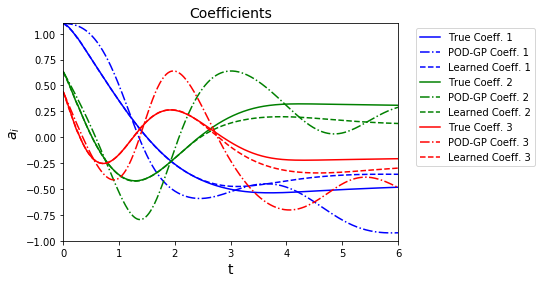

In [15]:
plot_obj = custom_plot(tf.concat([true_ai_red, val_true_ai_red], axis=0), ai_whole, tf.concat([t, val_t], axis=0), args)
plot_obj.plot(pred_y)

#### Save data for comparison

In [16]:
os.chdir(basedir)

data_dict = {'true_ai_red':true_ai_red, 'val_true_ai_red':val_true_ai_red,
             'ai':ai, 'val_ai':val_ai, 'pred_y': pred_y, 't': t, 'val_t': val_t}

with open(os.path.join('neuralClosureModels/final_paper_scripts', 'nDistDDE_C9_Exp1_predictions.pkl'), 'wb') as output:
    pickle.dump(data_dict, output, pickle.HIGHEST_PROTOCOL)

In [17]:
func_main.summary()

Model: "dde_func_main"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  30        
_________________________________________________________________
dense_1 (Dense)              multiple                  30        
_________________________________________________________________
dense_2 (Dense)              multiple                  18        
Total params: 78
Trainable params: 78
Non-trainable params: 0
_________________________________________________________________


In [18]:
func_aux.summary()

Model: "dde_func_aux"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              multiple                  12        
_________________________________________________________________
dense_4 (Dense)              multiple                  12        
_________________________________________________________________
dense_5 (Dense)              multiple                  8         
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
